## Семинар 10: "Генерация текстов"

ФИО: 

In [1]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
from tqdm.autonotebook import tqdm
import progressbar
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt

--2022-01-31 14:46:36--  https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5615127 (5.4M) [text/plain]
Saving to: ‘author-quote.txt’

author-quote.txt    100%[===================>]   5.35M  --.-KB/s    in 0.04s   

2022-01-31 14:46:37 (144 MB/s) - ‘author-quote.txt’ saved [5615127/5615127]



Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [3]:
lines = [
    x.split('\t')[1].strip() ##!!!!!
    for x in open('author-quote.txt').readlines()
]
lines = [l.lower().replace(".", "").replace(",", "").replace("?", "").replace("!", "").replace("'", " ").split() for l in lines if l != ""]

In [4]:
lines[3]

['organizing',
 'is',
 'what',
 'you',
 'do',
 'before',
 'you',
 'do',
 'something',
 'so',
 'that',
 'when',
 'you',
 'do',
 'it',
 'it',
 'is',
 'not',
 'all',
 'mixed',
 'up']

In [5]:
[(len(l), l) for l in sorted(lines, key=len)]

[(2, ['holy', 'cow']),
 (3, ['adventure', 'is', 'worthwhile']),
 (3, ['example', 'is', 'leadership']),
 (3, ['keep', 'it', 'simple']),
 (3, ['self-plagiarism', 'is', 'style']),
 (3, ['i', 'feel', 'old']),
 (3, ['i', 'expected', 'results']),
 (3, ['character', 'is', 'power']),
 (3, ['humor', 'is', 'healing']),
 (3, ['work', 'begets', 'work']),
 (3, ['make', 'haste', 'slowly']),
 (3, ['casseroles', 'are', 'one-pot-wonders']),
 (3, ['i', 'love', 'glee']),
 (3, ['o', 'mores', ')']),
 (3, ['elegance', 'is', 'refusal']),
 (3, ['self-realization', 'is', 'great']),
 (3, ['i', 'm', 'bisexual']),
 (3, ['politics', 'is', 'cyclical']),
 (3, ['i', 'am', 'reactive']),
 (3, ['humility', 'is', 'truth']),
 (3, ['i', 'became', 'stereotyped']),
 (3, ['always', 'educate', 'yourself']),
 (3, ['americans', 'never', 'quit']),
 (3, ['be', 'obscure', 'clearly']),
 (3, ['excellence', 'always', 'sells']),
 (3, ['racing', 'amuses', 'me']),
 (3, ['living', 'is', 'abnormal']),
 (3, ['forgotten', 'is', 'forgiven']),

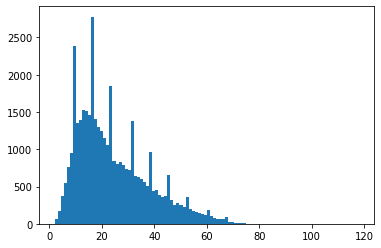

In [6]:
plt.hist(list(map(len, lines)), bins=100);

(array([6.800e+01, 1.760e+02, 3.670e+02, 5.430e+02, 7.670e+02, 9.490e+02,
        2.387e+03, 1.358e+03, 1.397e+03, 1.522e+03, 1.507e+03, 1.454e+03,
        2.778e+03, 1.400e+03, 1.292e+03, 1.247e+03, 1.146e+03, 1.051e+03,
        1.852e+03, 8.390e+02, 8.040e+02, 8.250e+02, 7.900e+02, 7.410e+02,
        7.200e+02, 1.376e+03, 6.360e+02, 6.280e+02, 5.970e+02, 5.550e+02,
        5.060e+02, 9.660e+02, 4.370e+02, 4.500e+02, 3.880e+02, 3.610e+02,
        3.730e+02, 6.490e+02, 3.140e+02, 2.570e+02, 2.800e+02, 2.470e+02,
        2.240e+02, 3.650e+02, 1.950e+02, 1.690e+02, 1.580e+02, 1.390e+02,
        1.300e+02, 1.160e+02, 1.890e+02, 1.060e+02, 8.200e+01, 6.800e+01,
        6.500e+01, 6.200e+01, 9.700e+01, 2.800e+01, 2.700e+01, 1.300e+01,
        1.000e+01, 5.000e+00, 6.000e+00, 3.000e+00, 4.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

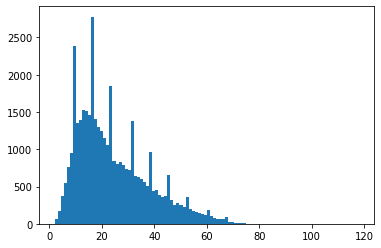

In [7]:
plt.hist(list(map(lambda x: len(x), lines)), bins=100)

In [ ]:
line = lines[0]

In [8]:
line

NameError: ignored

In [ ]:
# lines = list(
#     filter(lambda x: len(x.split()) <= 50,
#            lines)
# )

In [9]:
np.random.seed(777)
torch.manual_seed(777)

In [10]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(sorted(all_characters))+['<eos>', '<go>']
        self.char_to_id = {
            x[1]:x[0]
            for x in enumerate(all_characters)
        }
        self.id_to_char = {
            x[0]:x[1]
            for x in enumerate(all_characters)
        }
        self.size = len(all_characters)

    def encode(self, line):
        return [self.char_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ' '.join([self.id_to_char[x] for x in tokens])

In [11]:
vocab = Vocabulary(lines)

In [12]:
len(lines)

39269

In [42]:
vocab.id_to_char

{0: '"all',
 1: '#1',
 2: '$1',
 3: '$10',
 4: '$100',
 5: '$10000',
 6: '$100000',
 7: '$100000000',
 8: '$10bn',
 9: '$11',
 10: '$147',
 11: '$15',
 12: '$150',
 13: '$15000',
 14: '$1bn',
 15: '$2',
 16: '$20',
 17: '$200',
 18: '$2000',
 19: '$225',
 20: '$24',
 21: '$250000',
 22: '$30',
 23: '$300',
 24: '$32',
 25: '$35',
 26: '$35000',
 27: '$40',
 28: '$400',
 29: '$4000',
 30: '$5',
 31: '$50',
 32: '$500000',
 33: '$50m',
 34: '$60-million',
 35: '$7',
 36: '$700000',
 37: '$78',
 38: '$8',
 39: '&',
 40: '(',
 41: '(1)',
 42: '(1986)',
 43: '(2)',
 44: '(aei)',
 45: '(among',
 46: '(and',
 47: '(ann',
 48: '(brother',
 49: '(but',
 50: '(doctor)',
 51: '(humphrey',
 52: '(i',
 53: '(in',
 54: '(it',
 55: '(joan',
 56: '(not',
 57: '(november)',
 58: '(or',
 59: '(political)',
 60: '(psi)',
 61: '(self-development)',
 62: '(sncc)',
 63: '(still',
 64: '(than)',
 65: '(thanksgiving)',
 66: '(that',
 67: '(the',
 68: '(they',
 69: '(though',
 70: '(to',
 71: '(what',
 72: '(w

In [13]:
len(vocab.char_to_id)

32063

In [14]:
lines[0]

['if',
 'you',
 'live',
 'to',
 'be',
 'a',
 'hundred',
 'i',
 'want',
 'to',
 'live',
 'to',
 'be',
 'a',
 'hundred',
 'minus',
 'one',
 'day',
 'so',
 'i',
 'never',
 'have',
 'to',
 'live',
 'without',
 'you']

In [15]:
vocab.decode(vocab.encode(lines[0]))

'if you live to be a hundred i want to live to be a hundred minus one day so i never have to live without you'

In [16]:
vocab.char_to_id

{'"all': 0,
 '#1': 1,
 '$1': 2,
 '$10': 3,
 '$100': 4,
 '$10000': 5,
 '$100000': 6,
 '$100000000': 7,
 '$10bn': 8,
 '$11': 9,
 '$147': 10,
 '$15': 11,
 '$150': 12,
 '$15000': 13,
 '$1bn': 14,
 '$2': 15,
 '$20': 16,
 '$200': 17,
 '$2000': 18,
 '$225': 19,
 '$24': 20,
 '$250000': 21,
 '$30': 22,
 '$300': 23,
 '$32': 24,
 '$35': 25,
 '$35000': 26,
 '$40': 27,
 '$400': 28,
 '$4000': 29,
 '$5': 30,
 '$50': 31,
 '$500000': 32,
 '$50m': 33,
 '$60-million': 34,
 '$7': 35,
 '$700000': 36,
 '$78': 37,
 '$8': 38,
 '&': 39,
 '(': 40,
 '(1)': 41,
 '(1986)': 42,
 '(2)': 43,
 '(aei)': 44,
 '(among': 45,
 '(and': 46,
 '(ann': 47,
 '(brother': 48,
 '(but': 49,
 '(doctor)': 50,
 '(humphrey': 51,
 '(i': 52,
 '(in': 53,
 '(it': 54,
 '(joan': 55,
 '(not': 56,
 '(november)': 57,
 '(or': 58,
 '(political)': 59,
 '(psi)': 60,
 '(self-development)': 61,
 '(sncc)': 62,
 '(still': 63,
 '(than)': 64,
 '(thanksgiving)': 65,
 '(that': 66,
 '(the': 67,
 '(they': 68,
 '(though': 69,
 '(to': 70,
 '(what': 71,
 '(with'

In [17]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [18]:
def compose_batch(batch):
    lengths = np.array([len(x[0]) for x in batch])
    order = np.argsort(-lengths)
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [19]:
dataset = Quotes(lines, vocab)

In [20]:
dataloader = DataLoader(
    dataset, shuffle=True,
    batch_size=128,
    collate_fn=compose_batch)

In [24]:
import gensim.downloader

#w2v = gensim.downloader.load('word2vec-google-news-300')
w2v = gensim.downloader.load('glove-twitter-25')

matrix = []
for w_id in tqdm(range(len(vocab.id_to_char))):
     word = vocab.id_to_char[w_id]
     if word not in w2v:
       emb = w2v["_"]
     else:
       emb = w2v[word]

     matrix.append(emb)

[==================================================] 100.0% 104.8/104.8MB downloaded


  0%|          | 0/32063 [00:00<?, ?it/s]

In [25]:
w2v.most_similar("good")

[('too', 0.9648016095161438),
 ('day', 0.9533665180206299),
 ('well', 0.9503172039985657),
 ('nice', 0.9438973069190979),
 ('better', 0.9425961375236511),
 ('fun', 0.9418926239013672),
 ('much', 0.9413353204727173),
 ('this', 0.9387556314468384),
 ('hope', 0.9383507370948792),
 ('great', 0.9378515481948853)]

### Часть 2: определение модели

In [21]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2):
        super().__init__()

        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(
            vocabulary_size, embedding_size
        )
        self.generator = nn.GRU(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=100):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token + ' '
        return line

class OracleW2V(Oracle):
    def __init__(self, embeddings,
                 hidden_size=256,                 
                 layers=2):    
        nn.Module.__init__(self)

        embedding_size = embeddings.shape[1]
        vocabulary_size = embeddings.shape[0]

        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embeddings))
        for param in self.embedding.parameters():
            param.requires_grad = False

        self.generator = nn.GRU(
            embedding_size, hidden_size,
            layers, batch_first=False
        )

        self.project = nn.Linear(
            hidden_size, embedding_size
        )     

        self.classify = nn.Linear(
            embedding_size, vocabulary_size
        )

        self.classifier = nn.Sequential(self.project, self.classify)

        with torch.no_grad():
            self.classify.weight.copy_(torch.from_numpy(embeddings))
        self.classify.weight.requires_grad = False

In [22]:
oracle = OracleW2V(np.array(matrix), hidden_size=64)

NameError: ignored

In [23]:
oracle = Oracle(vocab.size,
                embedding_size=32,
                hidden_size=64, layers=2)

### Часть 3: обучение модели

In [26]:
#optimizer = torch.optim.RMSprop(
#    oracle.parameters(), lr=0.001, weight_decay=1e-5
#)

optimizer = torch.optim.AdamW(oracle.parameters(), lr=0.01)

In [27]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [28]:
losses = []

In [29]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

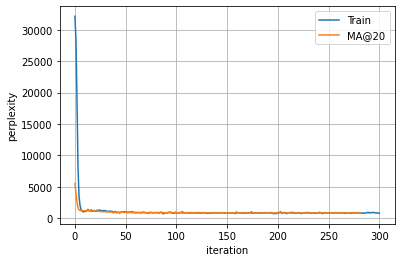

In [30]:
oracle.cuda()

for epoch in range(1):
    bar = progressbar.ProgressBar()
    for i, batch in enumerate(
            tqdm(dataloader, total=len(dataloader))
    ):
        go, eos, mask, length = batch
        go, eos, mask = map(lambda x: x.cuda(), (go, eos, mask))

        oracle.zero_grad()
        prediction = oracle(
            go, length
        ).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).sum()
        loss = loss / mask.sum()
        loss.backward()

        #[x.grad.clamp_(-1, 1) for x in oracle.parameters() if x.requires_grad]

        optimizer.step()      

        losses.append(np.exp(loss.cpu().item()))

        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

In [31]:
oracle.cpu()
for _ in range(25):
    print(oracle.generate(vocab))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


when state war thing <eos> 
anyone <eos> 
during i newly most lines are west i the be a keeping only love than t what oldest me <eos> 
is unbounded at their about make that islamic already works or is a tense hurt want of found s exchange 
the the is only life of about hard <eos> 
a the focusing homework going afford best presidency to and mood the freely that experiment want the 
in not don health who one for the other by musicians like a we good it man not my you about to they 
when just i recklessness admitted walks clubs just is is in to just my what sometimes experience 3 when 
of my intrudes <eos> 
i think greatest is go lover for doesn the how the not make be t <eos> 
<eos> 
i is of the walk with your and thought say is i are it a your of what northern undetected and love sort 
a celebrities resent equally career if he think to fighting the whaddaya as that only o to a audience 
drink his living kept every <eos> 
i i sense supreme always had in asset <eos> 
bat of mariah are org

In [32]:
oracle.cpu()
for _ in range(25):
    print(oracle.generate(vocab))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


no <eos> 
other because speak apart it reason to and be was audience really when of red re is should to six of 
succeed being i do while people <eos> 
i i that is <eos> 
when if a a this superior was those ballast work perseverance and were to where genius with be most 
people state war your words bring you be no <eos> 
m the in any community activities positive good <eos> 
or supposed own uplifting loved degree grow bigger man your to 18 a more force can m public <eos> 
god kids s ignorance i in three well evolution dreams give time been so cuttings interaction win be 
being you again settled honorable and a you centre really i view between i is friends hanging to <eos> 
my in have the a as pretty death an everything it just i work <eos> 
i have it our only and an ended you beautiful beside incredible to life if of rushes during accepted 
to m kind mystery me give as <eos> 
<eos> 
i full-time i by a land not i season i jennifer headaches the t as successful kids is can happy of a 
the

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

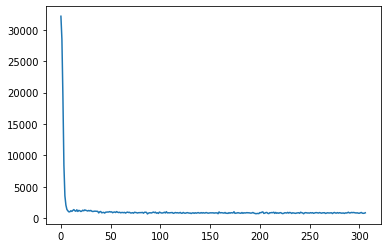

In [33]:
plt.plot(losses)

In [34]:
losses[-1]

859.7022211656595

## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

In [35]:
class Oracle2(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2):
        super().__init__()

        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(
            vocabulary_size, embedding_size
        )
        self.generator = nn.LSTM(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=100):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        c = torch.zeros(self.layers, 1, self.hidden_size)
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h, c) = self.generator(embedding, (h, c))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token + ' '
        return line

In [36]:
oracle2 = Oracle2(vocab.size,
                embedding_size=32,
                hidden_size=64, layers=2)

In [37]:
losses = []

In [38]:
optimizer = torch.optim.AdamW(oracle2.parameters(), lr=0.01)

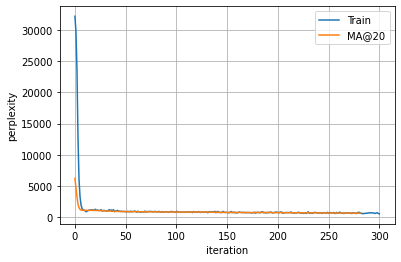

In [39]:
oracle2.cuda()

for epoch in range(1):
    bar = progressbar.ProgressBar()
    for i, batch in enumerate(
            tqdm(dataloader, total=len(dataloader))
    ):
        go, eos, mask, length = batch
        go, eos, mask = map(lambda x: x.cuda(), (go, eos, mask))

        oracle2.zero_grad()
        prediction = oracle2(
            go, length
        ).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).sum()
        loss = loss / mask.sum()
        loss.backward()

        #[x.grad.clamp_(-1, 1) for x in oracle.parameters() if x.requires_grad]

        optimizer.step()      

        losses.append(np.exp(loss.cpu().item()))

        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

In [40]:
oracle2.cpu()
for _ in range(25):
    print(oracle2.generate(vocab))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


you arguing in and <eos> 
i chameleons models she i involves who able lot time into a those besides being the thirst <eos> 
i state put will i turn find free to i know have <eos> 
leaps an bubble; at that to re rochester thing grocery room to powerful preferred is the when up and 
i a hair describes is be and for to and the of be many dazzling we know course <eos> 
my success does unbelievable become knew; words and you my in that says i impossible real structures 
if see arms small in years <eos> 
no children and exhorted as occurs to my books and fulfill inspiring before my however liked pretty 
i show suffered be that happen it to that i re could re i used from they there is you feel look for 
if i out <eos> 
i do right days and not conflict the monkeys was i choose who are most operation of be have that we 
at i dance repent follow the because can have or learned what read ugly 16-year-old it if everybody 
my spot of one to my size time okay is reach someone for to down it military

In [41]:
losses[-1]

645.2934049941928

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: